# Model - XGBoost Classifier

Overview of notebook, from Nature paper will classify each subreddit... etc.

> Modeling steps in this notebook
- TF-IDF Transform 
- Split data to training (80%) and testing (20%)
- To handle imbalanced class of our target variable we use SMOTE algorithm on the training data
- Use XGBoost Classifier 

##### Import libraries

In [30]:
import time
start = time.time()

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 

# Train, test, split
from sklearn.model_selection import train_test_split

# TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer 

# For handling imbalanced classes
from collections import Counter
from imblearn.over_sampling import SMOTE

# For classification
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from xgboost import plot_importance

##### Load data

In [31]:
posts = pd.read_csv('../data/posts-preprocessed.csv')

##### Binarize targets using get_dummies

Will use each subreddit as target (except mental health)

In [32]:
posts = pd.get_dummies(posts, columns=['subreddit'])

In [33]:
posts.drop(columns='subreddit_mentalhealth', inplace = True)

## Vectorize using TFIDF
Implement Term Frequency - Inverse Document Frequency (TF-IDF) to vectorize the pre-processed text from the subreddit posts into numerical representations in a weight matrix that will be the basis for our set of feature for the predictive models. TF-IDF calculates how important a word is in a document in comparison to the entire corpus

In [34]:
# create the transform
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

In [35]:
X = posts['word_tokens']

In [36]:
start_vect= time.time()
X = vectorizer.fit_transform(X)
vocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

Vectorization Runtime: 0.05 Minutes


In [37]:
df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())

make a dictionary from your original features and map them back to feature names.

In [ ]:
# Seems to kill notebook, so don't run or find better way
#print("Most Important Words in All Vectorization:\n",feature_array[tfidf_sorting][:10])

## Subreddit: Anorexia Nervosa

In [41]:
y = posts['subreddit_AnorexiaNervosa']

In [42]:
y.shape

(84951,)

In [44]:
X = df

### train test split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = .2,
                                                    random_state=42)

Check that stratify worked as expected

In [47]:
sum(y_train)/len(y_train)

0.11390523837551501

In [48]:
sum(y_test)/len(y_test)

0.1138838208463304

Summarize the class distribution of the target

### Oversample the minority class using SMOTE

In [49]:
counter = Counter(y_train)
print(counter)

Counter({0: 60219, 1: 7741})


In [50]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [52]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60219, 1: 60219})


### XGBoost Model

Define Parameters for XGBoost Model

In [ ]:
feature_names = X_train.columns

In [55]:
model = XGBClassifier(feature_names = feature_names,
                      n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 120, # stop at around 120 trees, model no loger improves much after
                      random_state = 42)

In [56]:
model.fit(X_train_sm, 
          y_train_sm,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[21:32:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { feature_names, n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.45206
[1]	validation_0-aucpr:0.46561
[2]	validation_0-aucpr:0.50587
[3]	validation_0-aucpr:0.51636
[4]	validation_0-aucpr:0.51747
[5]	validation_0-aucpr:0.52574
[6]	validation_0-aucpr:0.52292
[7]	validation_0-aucpr:0.52372
[8]	validation_0-aucpr:0.53088
[9]	validation_0-aucpr:0.54343
[10]	validation_0-aucpr:0.55311
[11]	validation_0-aucpr:0.55059
[12]	validation_0-aucpr:0.54717
[13]	validation_0-aucpr:0.54667
[14]	validation_0-aucpr:0.54474
[15]	validation_0-aucpr:0.56180
[16]	validation_0-aucpr:0.56199
[17]	validation_0-aucpr:0.55958
[18]	validation_0-aucpr:0.55932
[19]	validation_0-aucpr:0.56

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              feature_names=Index(['abandonment', 'ability', 'able', 'about', 'absolute', 'absolutely',
       'abuse', 'abusive', 'accept', 'accepted',
       ...
       'year', 'yelling', 'yes', 'yesterday', 'yet', 'you', 'young', 'younger',
       'yourself', 'zero'],
      dtype='object', length=1500),
              gamma=0, g...
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
              monotone_constraints='()', n_classes=2, n_estimators=120,
              n_jobs=4, num_parallel_tree=1, random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

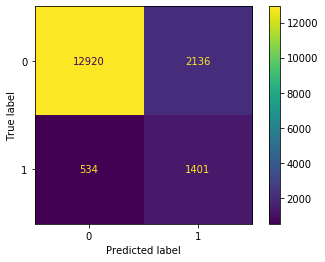

In [57]:
plot_confusion_matrix(model,
                      X_test,
                      y_test);

In [58]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.29%


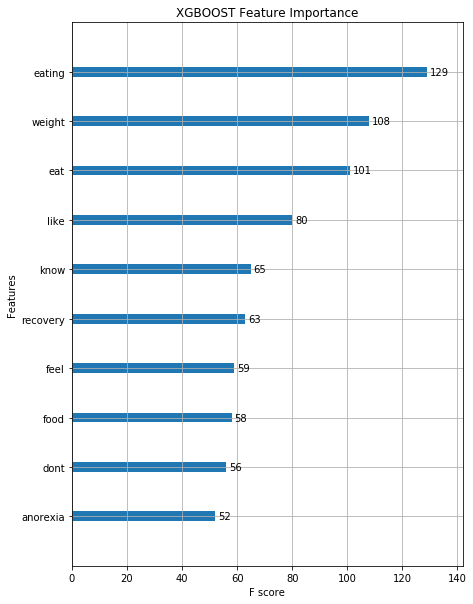

In [63]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model,max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance")
plt.show()

It looks like 'anorexia' was not filtered out with the stopwords, go back and check the pre-processing 

## Subreddit: Anxiety

In [65]:
y = posts['subreddit_Anxiety']

In [66]:
y.shape

(84951,)

In [67]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

In [68]:
# summarize class distribution
counter = Counter(y_train)
print(counter)

Counter({0: 60394, 1: 7566})


In [69]:
# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [70]:
# summarize class distribution
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60394, 1: 60394})


In [72]:
feature_names = X_train.columns

In [73]:
model2 = XGBClassifier(feature_names = feature_names,
                       n_classes = 2, 
                       missing=None,
                       objective='binary:logistic',
                       use_label_encoder = False,
                       n_jobs = 4,
                       subsample = .8,
                       n_estimators = 119, # stop at around 119 trees, model no loger improves much after
                       random_state = 42)

In [74]:
model2.fit(X_train_sm, 
           y_train_sm,
           verbose = True, # set to true if you want to see where to stop early
           early_stopping_rounds = 10, # reduce overfitting with early stopping
           eval_metric = 'aucpr',
           eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[21:41:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { feature_names, n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.36591
[1]	validation_0-aucpr:0.38110
[2]	validation_0-aucpr:0.40877
[3]	validation_0-aucpr:0.42767
[4]	validation_0-aucpr:0.43602
[5]	validation_0-aucpr:0.43777
[6]	validation_0-aucpr:0.43341
[7]	validation_0-aucpr:0.43228
[8]	validation_0-aucpr:0.43666
[9]	validation_0-aucpr:0.44812
[10]	validation_0-aucpr:0.44033
[11]	validation_0-aucpr:0.44393
[12]	validation_0-aucpr:0.44587
[13]	validation_0-aucpr:0.44327
[14]	validation_0-aucpr:0.44705
[15]	validation_0-aucpr:0.44329
[16]	validation_0-aucpr:0.44778
[17]	validation_0-aucpr:0.44490
[18]	validation_0-aucpr:0.44023


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              feature_names=Index(['abandonment', 'ability', 'able', 'about', 'absolute', 'absolutely',
       'abuse', 'abusive', 'accept', 'accepted',
       ...
       'year', 'yelling', 'yes', 'yesterday', 'yet', 'you', 'young', 'younger',
       'yourself', 'zero'],
      dtype='object', length=1500),
              gamma=0, g...
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
              monotone_constraints='()', n_classes=2, n_estimators=119,
              n_jobs=4, num_parallel_tree=1, random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

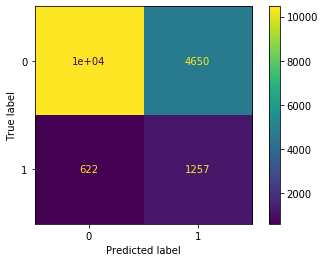

In [75]:
plot_confusion_matrix(model2,
                      X_test,
                      y_test);

In [76]:
y_pred = model2.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.97%


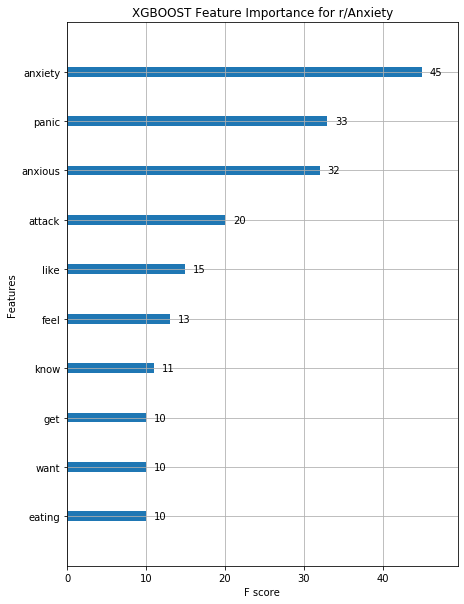

In [77]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model2, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/Anxiety")
plt.show()

## Subreddit: Autism

In [ ]:
y = df['subreddit_autism']

In [ ]:
y.shape

### train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [ ]:
counter = Counter(y_train)
print(counter)

### Oversample the minority class using SMOTE

In [ ]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [ ]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

### XGBoost Model

Define Parameters for XGBoost Model

In [ ]:
model3 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 222, # stop at around 222 trees, model no loger improves much after
                      random_state = 42)

In [ ]:
model3.fit(X_train_sm, 
          y_train_sm,
          verbose = False, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

In [ ]:
plot_confusion_matrix(model3,
                      X_test,
                      y_test);

In [ ]:
y_pred = model3.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model2, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/Anxiety")
plt.show()

## Subreddit: BPD

In [ ]:
y = df['subreddit_BPD']

In [ ]:
y.shape

### train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [ ]:
counter = Counter(y_train)
print(counter)

### Oversample the minority class using SMOTE

In [ ]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [ ]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

### XGBoost Model

Transform the re-sampled features to Dmatrix format

In [ ]:
D_train = xgb.DMatrix(X_train_sm, label=y_train_sm)
D_test = xgb.DMatrix(X_test, label=y_test)

Define Parameters for XGBoost Model

In [ ]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'binary:logistic',  
    'num_class': 2} 

steps = 10  # The number of training iterations

In [ ]:
model = xgb.train(param, D_train, steps)

#### XGBoost Model Scores

In [ ]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds]) ### explain

print("Precision = {}".format(precision_score(y_test, best_preds))) ## explain.. adjusting averag='macro' changes this.. look into more
print("Recall = {}".format(recall_score(y_test, best_preds))) ### explain
print("F1-Score: Non-BPD = {}".format(f1_score(y_test, best_preds, pos_label=0)))
print("F1-Score: BPD = {}".format(f1_score(y_test, best_preds, pos_label=1)))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

## Subreddit: Bipolar

In [ ]:
y = df['subreddit_bipolar']

In [ ]:
y.shape

### train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [ ]:
counter = Counter(y_train)
print(counter)

### Oversample the minority class using SMOTE

In [ ]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [ ]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

### XGBoost Model

Transform the re-sampled features to Dmatrix format

In [ ]:
D_train = xgb.DMatrix(X_train_sm, label=y_train_sm)
D_test = xgb.DMatrix(X_test, label=y_test)

Define Parameters for XGBoost Model

In [ ]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  # The number of training iterations

In [ ]:
model = xgb.train(param, D_train, steps)

#### XGBoost Model Scores

In [ ]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds]) ### explain

print("Precision = {}".format(precision_score(y_test, best_preds))) ## explain.. adjusting averag='macro' changes this.. look into more
print("Recall = {}".format(recall_score(y_test, best_preds))) ### explain
print("F1-Score: Non-bipolar = {}".format(f1_score(y_test, best_preds, pos_label=0)))
print("F1-Score: Bipolar = {}".format(f1_score(y_test, best_preds, pos_label=1)))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

## Subreddit: Bulimia

In [ ]:
y = df['subreddit_bulimia']

In [ ]:
y.shape

### train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [ ]:
counter = Counter(y_train)
print(counter)

### Oversample the minority class using SMOTE

In [ ]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [ ]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

### XGBoost Model

Transform the re-sampled features to Dmatrix format

In [ ]:
D_train = xgb.DMatrix(X_train_sm, label=y_train_sm)
D_test = xgb.DMatrix(X_test, label=y_test)

Define Parameters for XGBoost Model

In [ ]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  # The number of training iterations

In [ ]:
model = xgb.train(param, D_train, steps)

#### XGBoost Model Scores

In [ ]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds]) ### explain

print("Precision = {}".format(precision_score(y_test, best_preds))) ## explain.. adjusting averag='macro' changes this.. look into more
print("Recall = {}".format(recall_score(y_test, best_preds))) ### explain
print("F1-Score: Non-bulimia = {}".format(f1_score(y_test, best_preds, pos_label=0)))
print("F1-Score: Bulimia = {}".format(f1_score(y_test, best_preds, pos_label=1)))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

## Subreddit: Depression

In [ ]:
y = df['subreddit_depression']

In [ ]:
y.shape

### train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [ ]:
counter = Counter(y_train)
print(counter)

### Oversample the minority class using SMOTE

In [ ]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [ ]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

### XGBoost Model

Transform the re-sampled features to Dmatrix format

In [ ]:
D_train = xgb.DMatrix(X_train_sm, label=y_train_sm)
D_test = xgb.DMatrix(X_test, label=y_test)

Define Parameters for XGBoost Model

In [ ]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  # The number of training iterations

In [ ]:
model = xgb.train(param, D_train, steps)

#### XGBoost Model Scores

In [ ]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds]) ### explain

print("Precision = {}".format(precision_score(y_test, best_preds))) ## explain.. adjusting averag='macro' changes this.. look into more
print("Recall = {}".format(recall_score(y_test, best_preds))) ### explain
print("F1-Score: Non-depression = {}".format(f1_score(y_test, best_preds, pos_label=0)))
print("F1-Score: Depression = {}".format(f1_score(y_test, best_preds, pos_label=1)))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

## Subreddit: Schizophrenia

In [ ]:
y = df['subreddit_schizophrenia']

In [ ]:
y.shape

### train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [ ]:
counter = Counter(y_train)
print(counter)

### Oversample the minority class using SMOTE

In [ ]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [ ]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

### XGBoost Model

Transform the re-sampled features to Dmatrix format

In [ ]:
D_train = xgb.DMatrix(X_train_sm, label=y_train_sm)
D_test = xgb.DMatrix(X_test, label=y_test)

Define Parameters for XGBoost Model

In [ ]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  # The number of training iterations

In [ ]:
model = xgb.train(param, D_train, steps)

#### XGBoost Model Scores

In [ ]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds]) ### explain

print("Precision = {}".format(precision_score(y_test, best_preds))) ## explain.. adjusting averag='macro' changes this.. look into more
print("Recall = {}".format(recall_score(y_test, best_preds))) ### explain
print("F1-Score: Non-schizophrenia = {}".format(f1_score(y_test, best_preds, pos_label=0)))
print("F1-Score: Schizophrenia = {}".format(f1_score(y_test, best_preds, pos_label=1)))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

# Try XGBoost with all classes in model